In [1]:
include("XYCore.jl")
using .XYCore
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Optimisers, Logging, LinearAlgebra, Statistics, StatsBase, ProgressMeter
using CairoMakie

init_logger(dir="../../logs", level=:Info)
println(names(XYCore))

[:XYCore, :calc_acceptance_and_rtt, :calc_energy, :calc_magnetization, :initial_state, :metropolis_sampler, :score_method, :wolff_sampler]


In [2]:
N = 20
β_min = 0.5
β_max = 2.0
M = 20
η = 0.001
# target = 0.5
mcSteps = 10^3
eqSteps = 10^4
epochs = 300
batch_size = 10
@info """
Hyperparameters of XY model:
--------------------
system size: $(N*N),
the number of replica: $M,
MCS: $mcSteps
"""
println("Set hyperparameters.")

Set hyperparameters.


In [3]:
init_β_ladder = Utils.set_temperature_ladder(
    β_min, 
    β_max; 
    M=M, 
    method=:geometric
)
exchange_prob_means, _ = XYCore.calc_acceptance_and_rtt(N, init_β_ladder)

println(init_β_ladder)
println(exchange_prob_means)

[0.5000000000000004, 0.5378452931100917, 0.5785551186413602, 0.6223462947320121, 0.6694520506122364, 0.7201232687693798, 0.7746298211333282, 0.8332620063985448, 0.8963320961378562, 0.9641759979424954, 1.0371550444461923, 1.115657917761544, 1.2001027195781033, 1.2909391979474052, 1.3886511426146564, 1.493758961654486, 1.606822453133765, 1.7284437865632112, 1.8592707100168127, 2.0]
[0.5391225564912947, 0.5115440341878981, 0.4658448228040481, 0.42142384955522355, 0.3725768229770137, 0.33494201220530795, 0.26701171436723353, 0.21496386032235681, 0.21770892783389892, 0.27139899548033175, 0.2872049530238893, 0.3198077360437262, 0.3601816876855483, 0.3772266879156132, 0.38918276948967423, 0.3984889555469677, 0.42962139916271536, 0.41726940174730637, 0.41196912911753536]


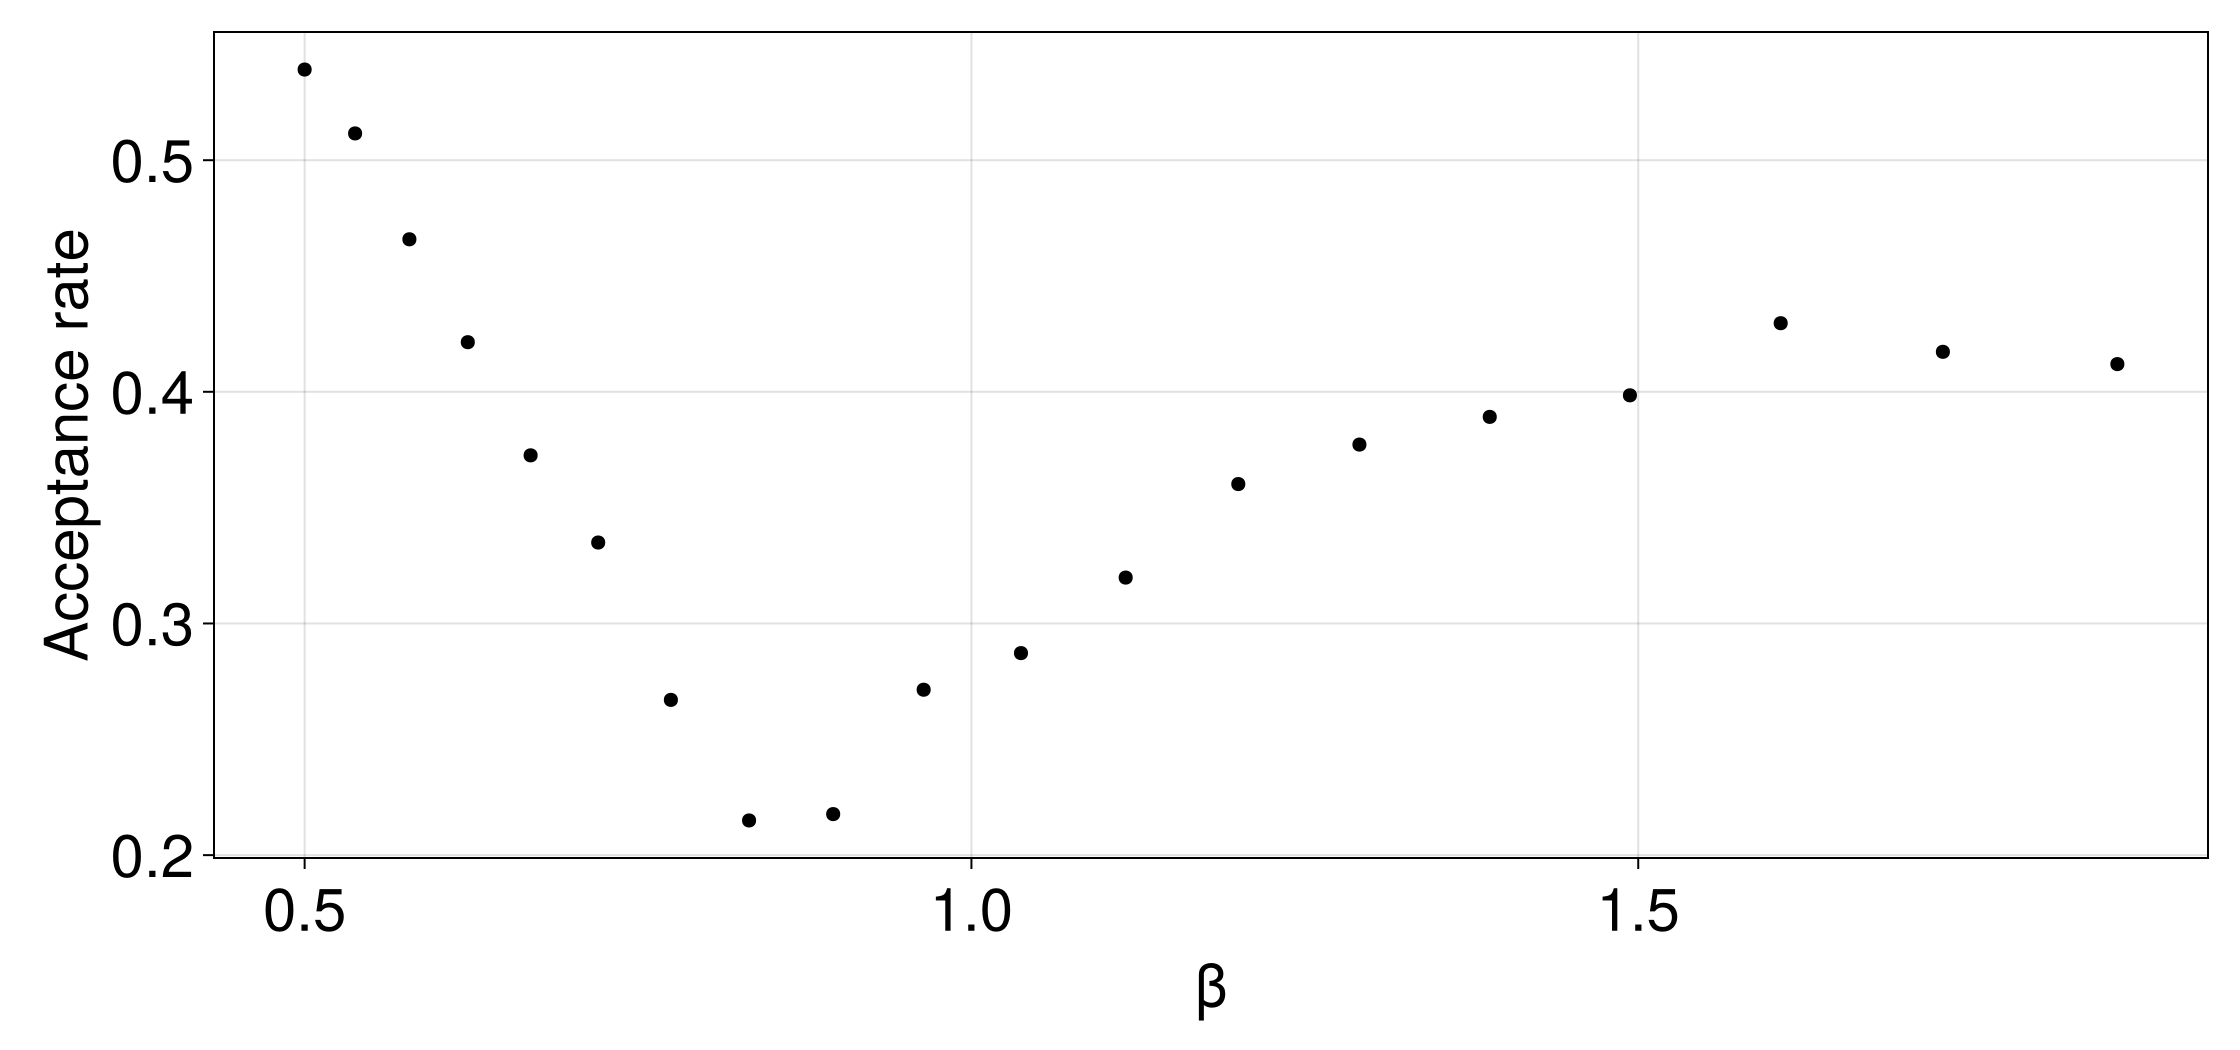

CairoMakie.Screen{IMAGE}


In [4]:
begin
    fig1 = Figure(size=(1120, 525), fontsize = 30)
    ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
    scatter!(ax1, init_β_ladder[1:(end-1)], exchange_prob_means, color=:black, markersize=10)
    
    display(fig1)
end

In [5]:
β_ladder = deepcopy(init_β_ladder)
β_ladder_trace = [β_ladder]
optimizer = Adam(η)
setup = Optimisers.setup(optimizer, β_ladder)

exchange_prob_trace = [exchange_prob_means]
# init_loss = Statistics.mean((exchange_prob_means .- target).^2)
init_loss = Statistics.var(exchange_prob_means)
loss_trace = [init_loss]

@showprogress for epoch in 1:epochs
    samples = []
    for _ in 1:batch_size
        grad, exchange_prob_means = XYCore.score_method(
            N, 
            β_ladder;
            mcSteps=mcSteps, 
            eqSteps=eqSteps,
            exchange_interval=1,
            # target=target
        )
        push!(samples, grad)
    end
    # loss_func = Statistics.mean((exchange_prob_means .- target).^2)
    loss_func = Statistics.var(exchange_prob_means)
    grad_mean = Statistics.mean(samples)
    grad_std = Statistics.std(samples)
    # grad_mean[end] = 0.0
    setup, β_ladder = Optimisers.update(setup, β_ladder, grad_mean)

    push!(β_ladder_trace, deepcopy(β_ladder))
    push!(exchange_prob_trace, exchange_prob_means)
    push!(loss_trace, loss_func)

    formatted_grads = [
        "$(round(mean_val, digits=5)) ± $(round(std_val, digits=5))"
        for (mean_val, std_val) in zip(grad_mean, grad_std)
    ]
    grad_str = join(formatted_grads, ", ")

    @info """
    Epoch $epoch: 
    --------------------
    Mean Gradient: [$grad_str], 
    exchange probs: $exchange_prob_means, 
    loss function: $loss_func
    """
end

Progress: 100%|█████████████████████████████████████████| Time: 10:11:25


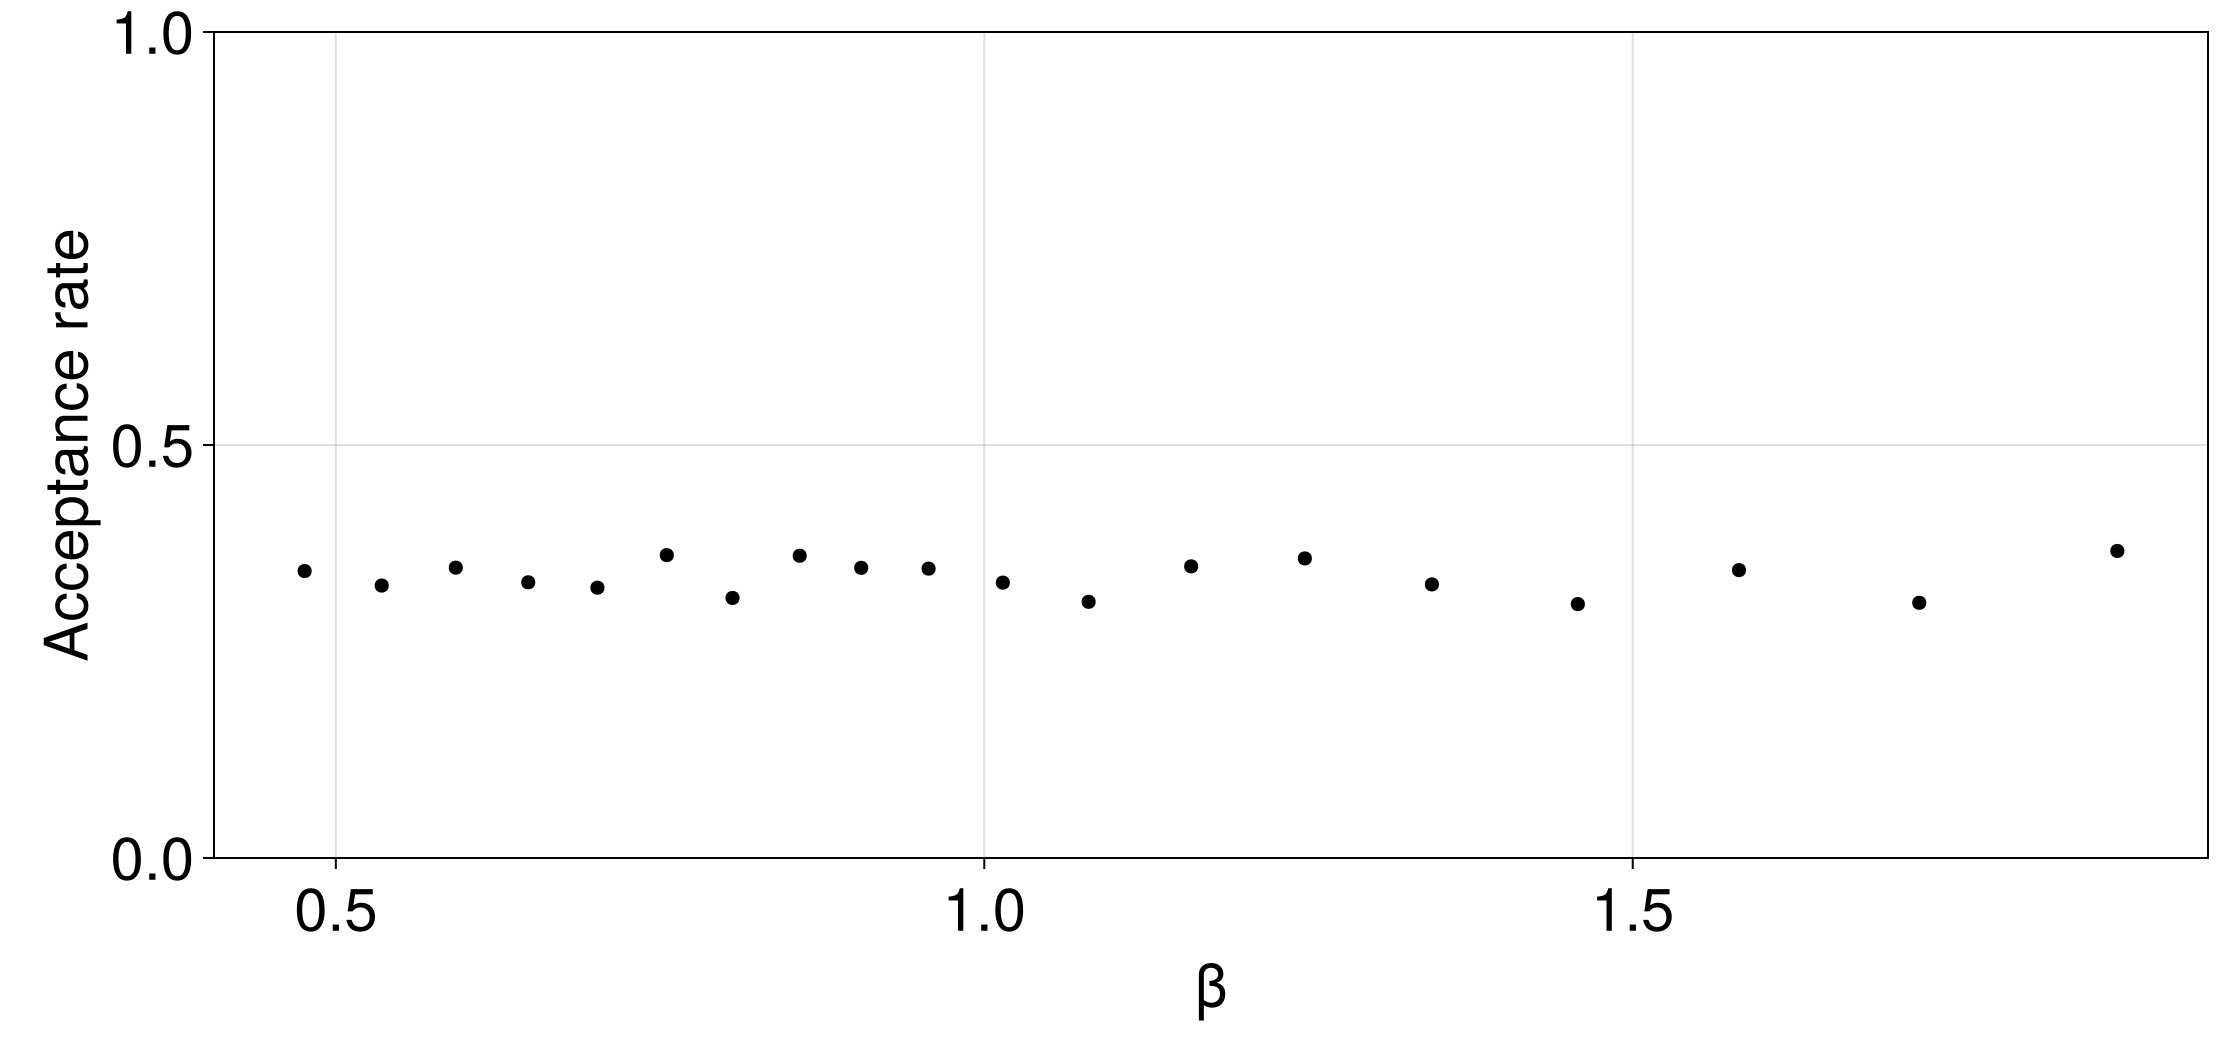

CairoMakie.Screen{IMAGE}


In [6]:
fig1 = Figure(size=(1120, 525), fontsize = 30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
ylims!(ax1, 0, 1)
scatter!(ax1, β_ladder_trace[end][1:(end-1)], exchange_prob_means, color=:black, markersize=10)

display(fig1)

In [7]:
dir = "../../plots/XY_model/L=$N/M=$M"
if dir !== nothing
    mkpath(dir)
end

"../../plots/XY_model/L=20/M=20"

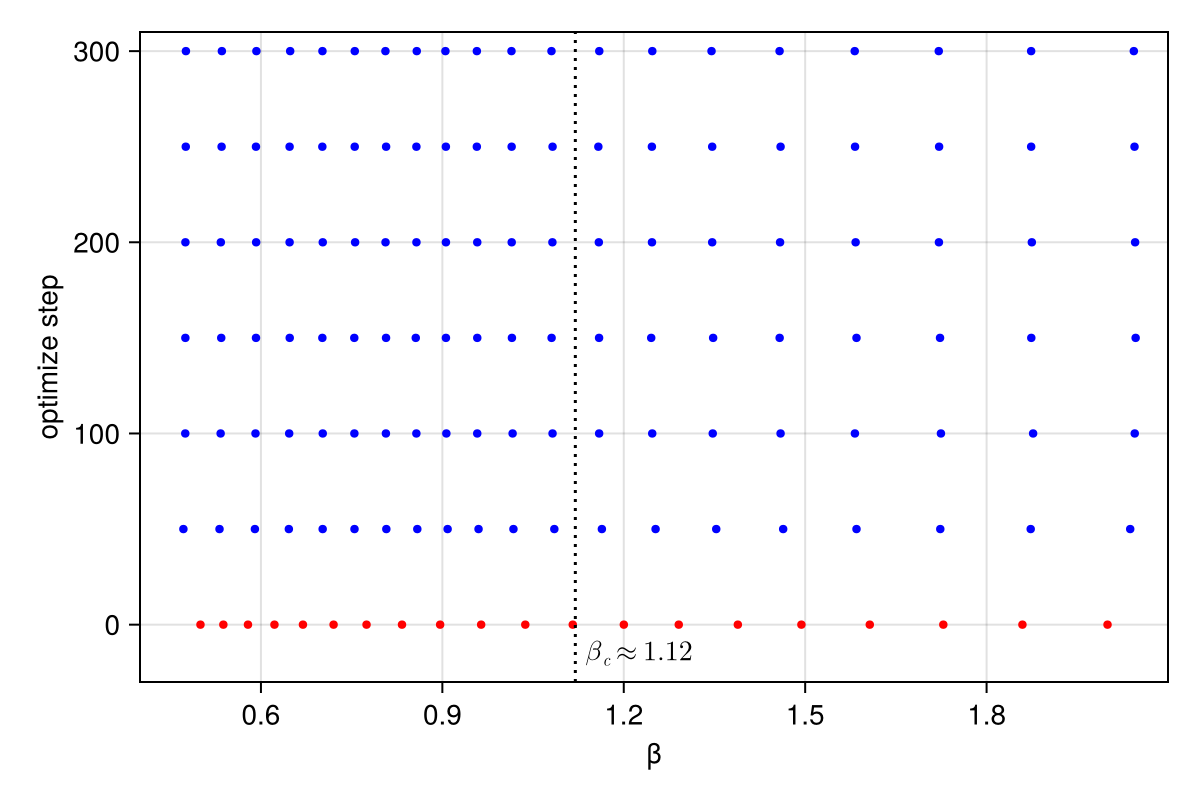

In [8]:
fig = Figure(font="Computer Modern", size=(600, 400))
ax = Axis(fig[1, 1],
    xlabel = "β",
    ylabel = "optimize step"
)
xlims!(ax, 0.4, 2.1)
ylims!(ax, -30, epochs+10)

plot_interval = 50
for (i, β_ladder) in enumerate(β_ladder_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        β_values = β_ladder
        y_values = fill(step, length(β_values))
        marker_color = (step == 0) ? :red : :blue

        scatter!(ax, β_values, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end
β_c = 1.1199
vlines!(ax, [β_c], color=:black, linestyle=:dot, label="Critical βc")
text!(
    ax,
    L"\beta_c \approx %$(round(β_c, digits=3))", 
    position = (β_c, -15), 
    align = (:left, :center), 
    offset = (5, 0)
)
display(fig)
save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs.png", fig; px_per_unit=4)

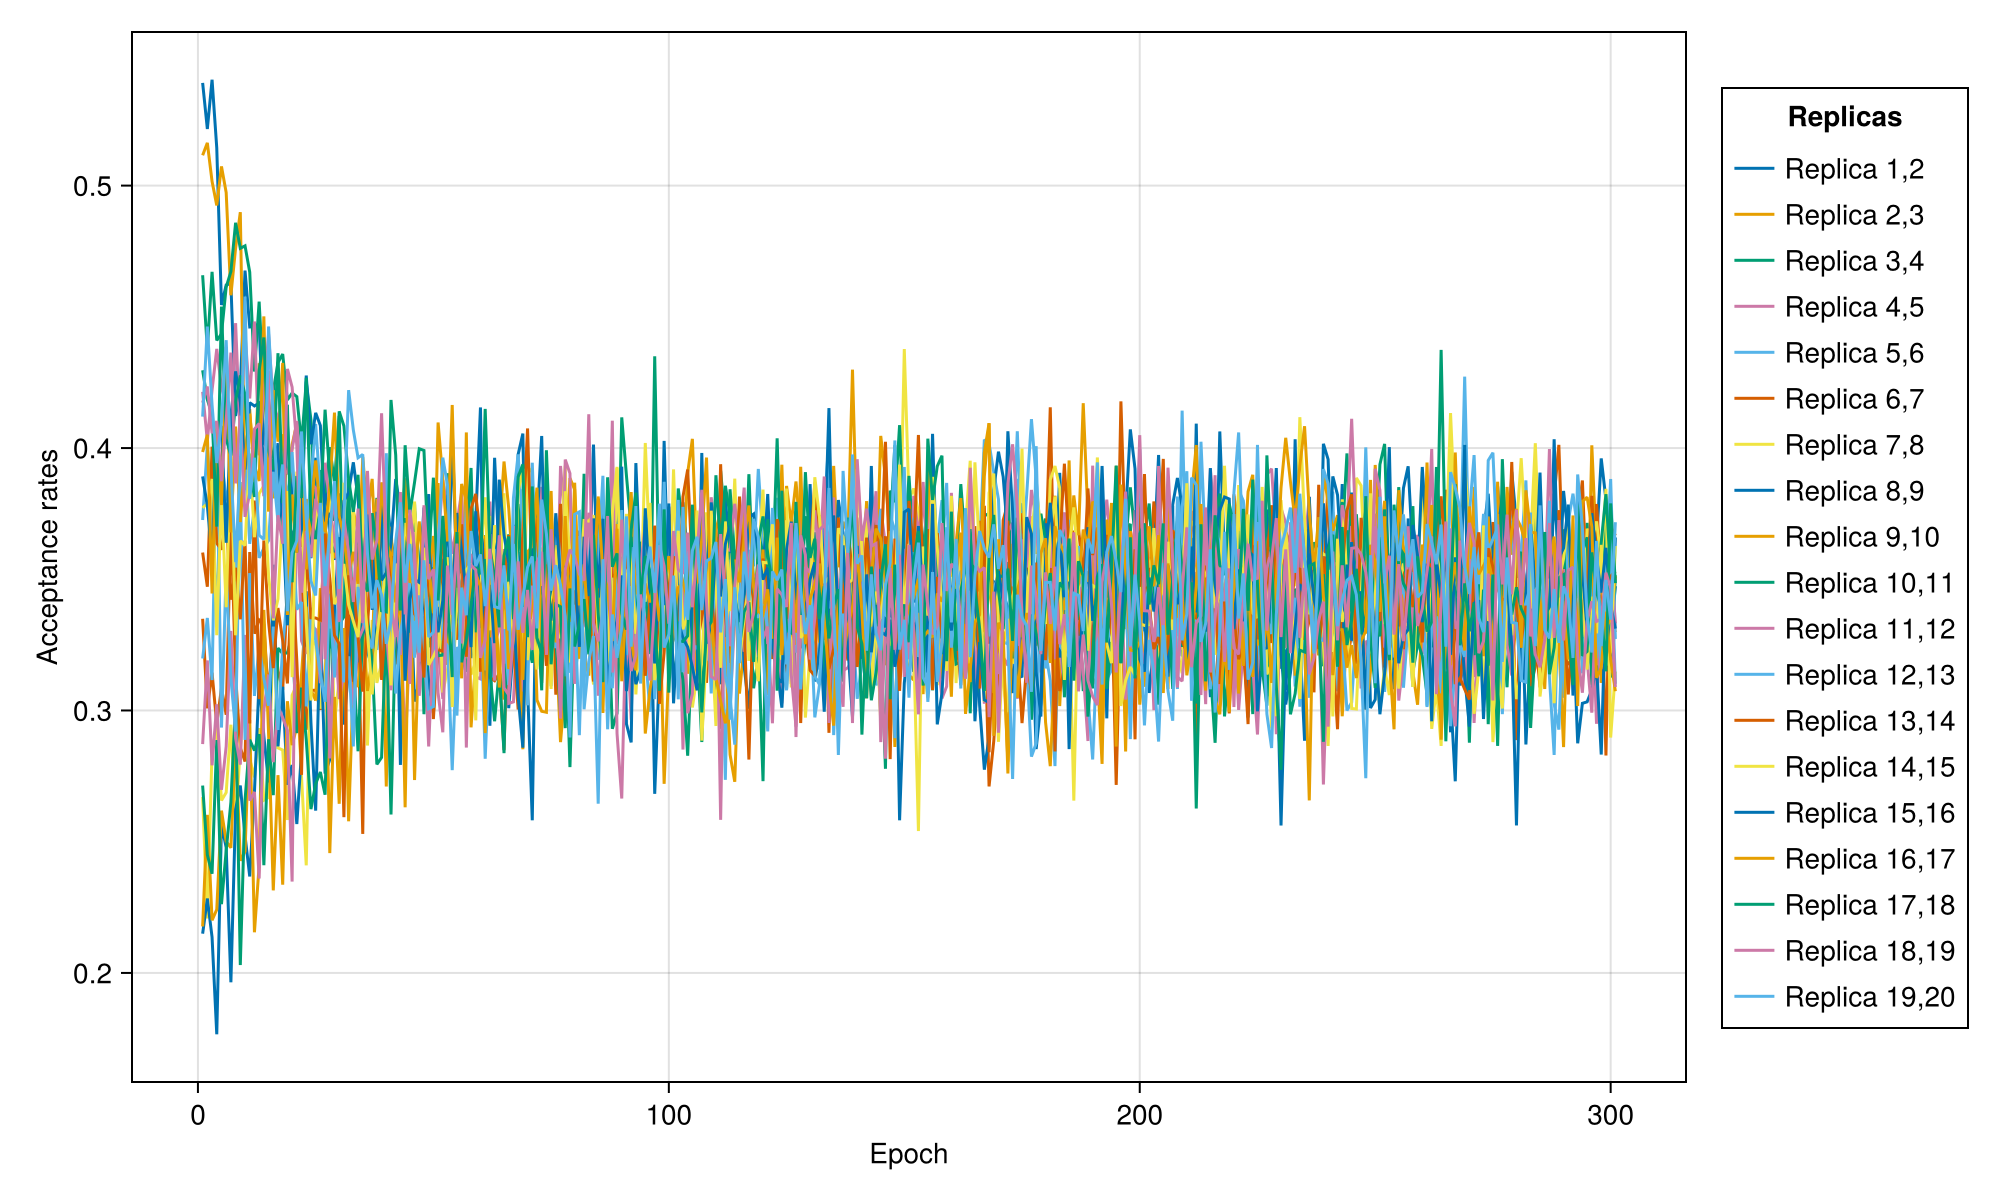

In [9]:
data = hcat(exchange_prob_trace...)
fig2 = Figure(size=(1000, 600))
ax2  = Axis(
    fig2[1, 1], 
    # title = "Replica Exchange Probabilities over Epochs", 
    xlabel = "Epoch", 
    ylabel = "Acceptance rates"
)
for i in 1:(M-1)
    lines!(ax2, 1:(epochs+1), data[i, :], label = "Replica $i,$(i+1)")
end

Legend(fig2[1, 2], ax2, "Replicas")

# axislegend(ax2; position = :rt)
display(fig2)
save("$dir/Replica Exchange Probabilities over Epochs.png", fig2; px_per_unit=4)

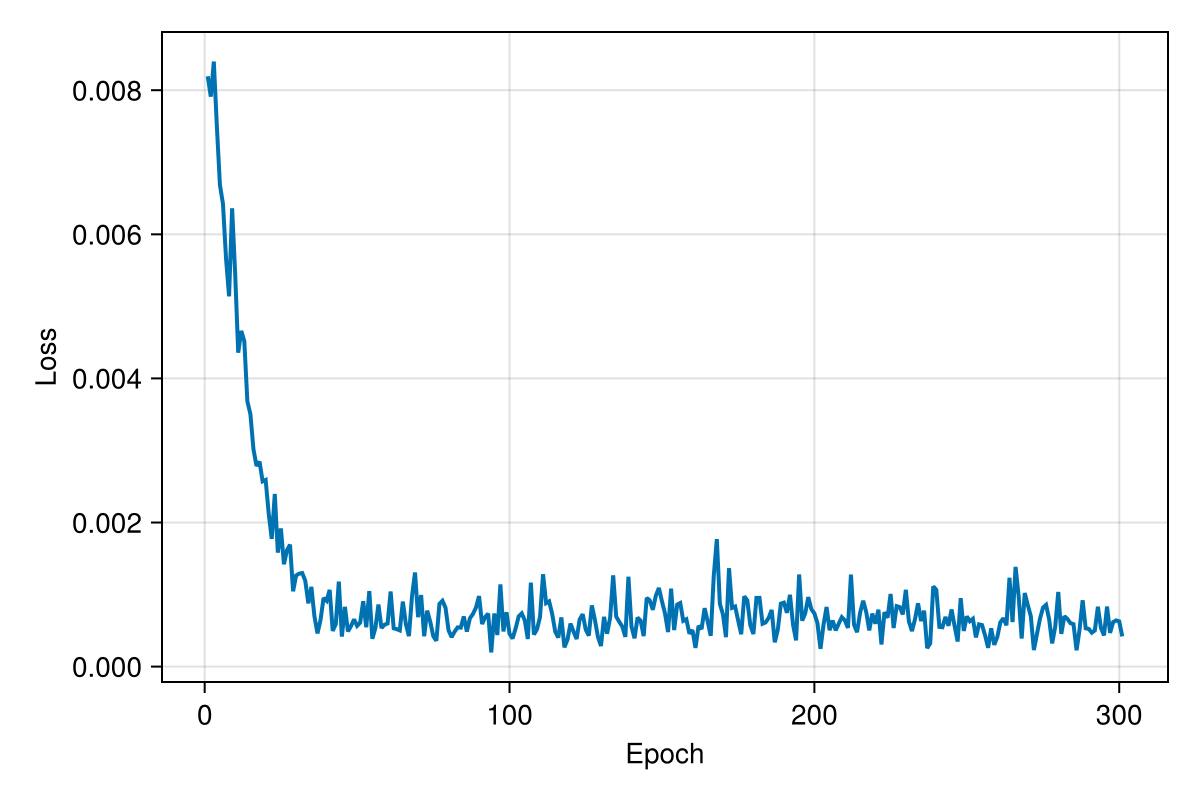

In [10]:
fig3 = Figure(size=(600, 400))
ax3 = Axis(
    fig3[1, 1]; 
    # title = "Loss function", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)
lines!(ax3, 1:(epochs+1), loss_trace; linewidth = 2)
# scatter!(ax3, 1:n, loss_trace; markersize = 4)

display(fig3)
save("$dir/Loss function.png", fig3; px_per_unit=4)

In [11]:
println(β_ladder_trace[end])

[0.47593580087561166, 0.535379056999381, 0.5924877332772561, 0.6483596687563973, 0.7017137814971617, 0.7551832585432775, 0.8058704255396851, 0.8576728388117075, 0.9050974434574456, 0.9570586992972345, 1.01431243139602, 1.0804615403008042, 1.1595128155639038, 1.2471819027507942, 1.345139094693069, 1.457665849178818, 1.5819539644148457, 1.7209059743938815, 1.8736812041101312, 2.0434863818617166]
